In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyart.graph.cm as pcm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import pandas as pd
import scipy.interpolate as interpolate
import sharppy.sharptab as tab
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level
%matplotlib inline

In [4]:
#..
cita_leg0_s = 13.8964   #
cita_leg0_e = 14.0050   #
cita_leg1_s = 14.0358      #
cita_leg1_e = 14.2197      #
cita_leg2_s = 14.2644         #
cita_leg2_e = 14.5422         #
cita_leg3_s = 14.5839      #
cita_leg3_e = 14.6961      #
cita_leg4_s = 14.7292   #
cita_leg4_e = 14.9047   #
#..

In [5]:
t_start = cita_leg2_s
t_end   = cita_leg2_e

In [20]:
#..Look at citation time and altitude
cal_filenm = '/mnt/raid/afridlin/data/mc3e/sband-kazr-williams/sbd_kaz_minute_cal_n5snr_20110520_v20150218.nc'
oth_filenm = '/home/mvanlier/mvanlier/sband_cwilliams/sbd_spc_raw_mom_20110520_140000_2015_0309.nc'
#oth_filenm = '/home/mvanlier/mvanlier/sband_cwilliams/sgpsbdprecipspcC1.a2.20110520.140000.nc'
#..
nc = Dataset(cal_filenm,'r')
zax_c  = nc.variables['sbd_kaz_range'][:] + 320.  #..Convert to altitude above MSL
#vsig_c = nc.variables['kaz_Vsig'][:,:]
kaz_vavg_c = nc.variables['kaz_Vmean'][:,:]
sbd_vavg_c = nc.variables['sbd_Vmean'][:,:]
kaz_zdbz_c = nc.variables['kaz_zdb_adjusted'][:,:]
sbd_zdbz_c = nc.variables['sbd_zdb'][:,:]
time_c = np.linspace(11.,16.,num=kaz_vavg_c.shape[0])
nc.close()
#..
nc = Dataset(oth_filenm,'r')
zax_o      = nc.variables['sbd_range'][:] + 320.  #..Convert to altitude above MSL
time_o     = (nc.variables['sbd_time_hour'][:]+nc.variables['sbd_time_minute'][:]/60.+
              nc.variables['sbd_time_second'][:]/3600.)
sbd_vavg_o = nc.variables['sbd_Vmean'][:,:]
sbd_zdbz_o = nc.variables['sbd_zdb'][:,:]
nc.close()
#nc = Dataset(oth_filenm,'r')
#zax_o  = 
#..

#..Now chop
logcon_c = np.logical_and(time_c>t_start,time_c<t_end)
kaz_vavg_c = kaz_vavg_c[logcon_c,:]
sbd_vavg_c = sbd_vavg_c[logcon_c,:]
kaz_zdbz_c = kaz_zdbz_c[logcon_c,:]
sbd_zdbz_c = sbd_zdbz_c[logcon_c,:]
time_c = time_c[logcon_c]

logcon_o = np.logical_and(time_o>t_start,time_o<t_end)
sbd_vavg_o = sbd_vavg_o[logcon_o,:]
sbd_zdbz_o = sbd_zdbz_o[logcon_o,:]
time_o = time_o[logcon_o]


(0, 10000.0)

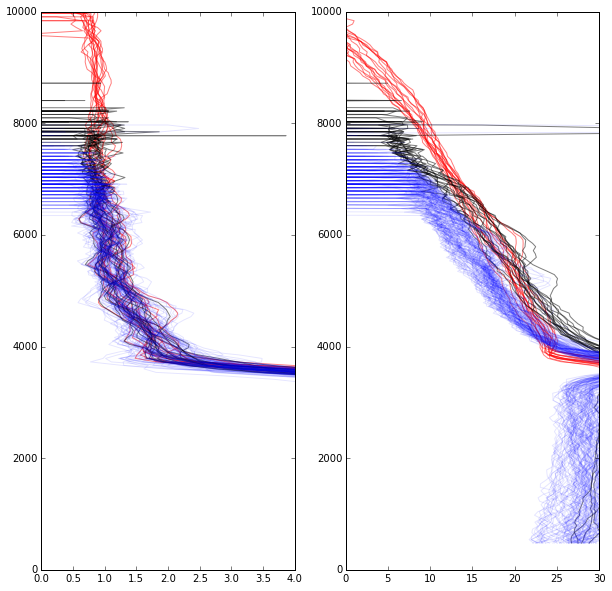

In [19]:
#..plot
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(121)
arr = ax.plot(kaz_vavg_c.T,zax_c,'r',alpha=.5)
arr = ax.plot(sbd_vavg_c.T,zax_c,'k',alpha=.5)
arr = ax.plot(sbd_vavg_o.T,zax_o,'b',alpha=.1)

ax.set_xlim(0,4.)
ax.set_ylim(0,10000.)
#..
ax = fig.add_subplot(122)
arr = ax.plot(kaz_zdbz_c.T,zax_c,'r',alpha=.5)
arr = ax.plot(sbd_zdbz_c.T,zax_c,'k',alpha=.5)
arr = ax.plot(sbd_zdbz_o.T,zax_o,'b',alpha=.1)
ax.set_xlim(0.,30.)
ax.set_ylim(0,10000.)
#..

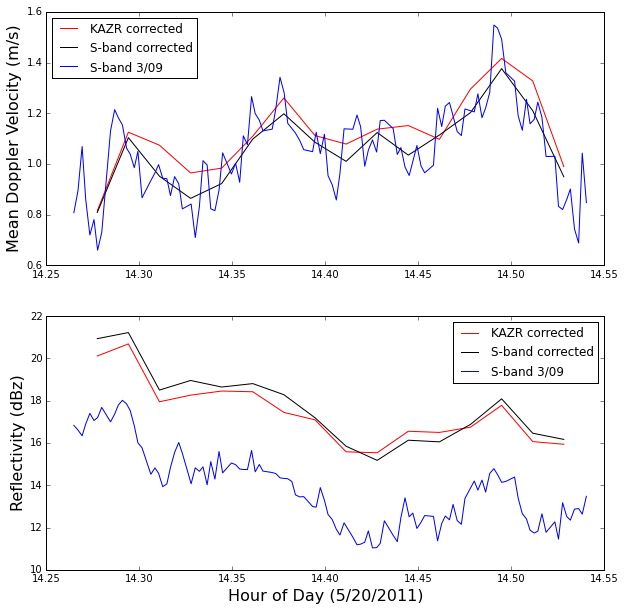

In [35]:
#..Look at time series
#..Get Citation altitude
filenm = '/mnt/raid/afridlin/data/mc3e/citation-nasa-und/data/QC_Processed/20110520_125403/11_05_20_12_54_03.mc3e'
nev_df = pd.read_table(filenm, delim_whitespace=True, header=[60,61])
altarr = nev_df['POS_Alt'].values
timarr = nev_df['Time'].values/3600.
logcon = np.logical_and(timarr>t_start,timarr<t_end)
alt_cita = altarr[logcon].mean()

alt_cita= 6000.

#..Get index of this alt
zidx_c = np.argmin(abs(zax_c-alt_cita))
zidx_o = np.argmin(abs(zax_o-alt_cita))

#..
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
plt.plot(time_c,kaz_vavg_c[:,zidx_c],'r',label='KAZR corrected')
plt.plot(time_c,sbd_vavg_c[:,zidx_c],'k',label='S-band corrected')
plt.plot(time_o,sbd_vavg_o[:,zidx_o],'b',label='S-band 3/09')
ax.legend(loc=2)
ax.set_ylabel('Mean Doppler Velocity (m/s)',fontsize=16)

#..
ax = fig.add_subplot(212)
plt.plot(time_c,kaz_zdbz_c[:,zidx_c],'r',label='KAZR corrected')
plt.plot(time_c,sbd_zdbz_c[:,zidx_c],'k',label='S-band corrected')
plt.plot(time_o,sbd_zdbz_o[:,zidx_o],'b',label='S-band 3/09')
ax.legend()
ax.set_ylabel('Reflectivity (dBz)',fontsize=16)
ax.set_xlabel('Hour of Day (5/20/2011)',fontsize=16)
